In [1]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-

"""Implements Partial Directed Coherence and Direct Transfer Function
using MVAR processes.
Reference
---------
Luiz A. Baccala and Koichi Sameshima. Partial directed coherence:
a new concept in neural structure determination.
Biological Cybernetics, 84(6):463:474, 2001.
"""

# Authors: Alexandre Gramfort <alexandre.gramfort@telecom-paristech.fr>
#
# License: BSD (3-clause)

'Implements Partial Directed Coherence and Direct Transfer Function\nusing MVAR processes.\nReference\n---------\nLuiz A. Baccala and Koichi Sameshima. Partial directed coherence:\na new concept in neural structure determination.\nBiological Cybernetics, 84(6):463:474, 2001.\n'

In [2]:
import math
import numpy as np
from scipy import linalg, fftpack
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
def mvar_generate(A, n, sigma, burnin=500):
    """Simulate MVAR process
    Parameters
    ----------
    A : ndarray, shape (p, N, N)
        The AR coefficients where N is the number of signals
        and p the order of the model.
    n : int
        The number of time samples.
    sigma : array, shape (N,)
        The noise for each time series
    burnin : int
        The length of the burnin period (in samples).
    Returns
    -------
    X : ndarray, shape (N, n)
        The N time series of length n
    """
    p, N, N = A.shape
    A_2d = np.concatenate(A, axis=1)
    Y = np.zeros((n + burnin, N))

    sigma = np.diag(sigma)
    mu = np.zeros(N)

    # itération du processus
    for i in range(p, n):
        w = np.random.multivariate_normal(mu, sigma)
        Y[i] = np.dot(A_2d, Y[i - p:i][::-1, :].ravel()) + w

    return Y[burnin:].T

In [4]:
def cov(X, p):
    """vector autocovariance up to order p
    Parameters
    ----------
    X : ndarray, shape (N, n)
        The N time series of length n
    Returns
    -------
    R : ndarray, shape (p + 1, N, N)
        The autocovariance up to order p
    """
    N, n = X.shape
    R = np.zeros((p + 1, N, N))
    for k in range(p + 1):
        R[k] = (1. / float(n - k)) * np.dot(X[:, :n - k], X[:, k:].T)
    return R

In [5]:
def mvar_fit(X, p):
    """Fit MVAR model of order p using Yule Walker
    Parameters
    ----------
    X : ndarray, shape (N, n)
        The N time series of length n
    n_fft : int
        The length of the FFT
    Returns
    -------
    A : ndarray, shape (p, N, N)
        The AR coefficients where N is the number of signals
        and p the order of the model.
    sigma : array, shape (N,)
        The noise for each time series
    """
    N, n = X.shape
    gamma = cov(X, p)  # gamma(r,i,j) cov between X_i(0) et X_j(r)
    G = np.zeros((p * N, p * N))
    gamma2 = np.concatenate(gamma, axis=0)
    gamma2[:N, :N] /= 2.

    for i in range(p):
        G[N * i:, N * i:N * (i + 1)] = gamma2[:N * (p - i)]

    G = G + G.T  # big block matrix

    gamma4 = np.concatenate(gamma[1:], axis=0)

    phi = linalg.solve(G, gamma4)  # solve Yule Walker

    tmp = np.dot(gamma4[:N * p].T, phi)
    sigma = gamma[0] - tmp - tmp.T + np.dot(phi.T, np.dot(G, phi))

    phi = np.reshape(phi, (p, N, N))
    for k in range(p):
        phi[k] = phi[k].T

    return phi, sigma

In [6]:
def compute_order(X, p_max):
    """Estimate AR order with BIC
    Parameters
    ----------
    X : ndarray, shape (N, n)
        The N time series of length n
    p_max : int
        The maximum model order to test
    Returns
    -------
    p : int
        Estimated order
    bic : ndarray, shape (p_max + 1,)
        The BIC for the orders from 0 to p_max.
    """
    N, n = X.shape

    bic = np.empty(p_max + 1)
    bic[0] = np.inf # XXX

    Y = X.T

    for p in range(1, p_max + 1):
        print(p)
        A, sigma = mvar_fit(X, p)
        A_2d = np.concatenate(A, axis=1)

        n_samples = n - p
        bic[p] = n_samples * N * math.log(2. * math.pi)
        bic[p] += n_samples * np.log(linalg.det(sigma))
        bic[p] += p * (N ** 2) * math.log(n_samples)

        sigma_inv = linalg.inv(sigma)
        S = 0.
        for i in range(p, n):
            res = Y[i] - np.dot(A_2d, Y[i - p:i][::-1, :].ravel())
            S += np.dot(res, sigma_inv.dot(res))

        bic[p] += S

    p = np.argmin(bic)
    return p, bic

In [7]:
def spectral_density(A, n_fft=None):
    """Estimate PSD from AR coefficients
    Parameters
    ----------
    A : ndarray, shape (p, N, N)
        The AR coefficients where N is the number of signals
        and p the order of the model.
    n_fft : int
        The length of the FFT
    Returns
    -------
    fA : ndarray, shape (n_fft, N, N)
        The estimated spectral density.
    """
    p, N, N = A.shape
    if n_fft is None:
        n_fft = max(int(2 ** math.ceil(np.log2(p))), 512)
    A2 = np.zeros((n_fft, N, N))
    A2[1:p + 1, :, :] = A  # start at 1 !
    fA = fftpack.fft(A2, axis=0)
    freqs = fftpack.fftfreq(n_fft)
    I = np.eye(N)

    for i in range(n_fft):
        fA[i] = linalg.inv(I - fA[i])

    return fA, freqs

In [8]:
def DTF(A, sigma=None, n_fft=None):
    """Direct Transfer Function (DTF)
    Parameters
    ----------
    A : ndarray, shape (p, N, N)
        The AR coefficients where N is the number of signals
        and p the order of the model.
    sigma : array, shape (N, )
        The noise for each time series
    n_fft : int
        The length of the FFT
    Returns
    -------
    D : ndarray, shape (n_fft, N, N)
        The estimated DTF
    """
    p, N, N = A.shape

    if n_fft is None:
        n_fft = max(int(2 ** math.ceil(np.log2(p))), 512)

    H, freqs = spectral_density(A, n_fft)
    D = np.zeros((n_fft, N, N))

    if sigma is None:
        sigma = np.ones(N)

    for i in range(n_fft):
        S = H[i]
        V = (S * sigma[None, :]).dot(S.T.conj())
        V = np.abs(np.diag(V))
        D[i] = np.abs(S * np.sqrt(sigma[None, :])) / np.sqrt(V)[:, None]

    return D, freqs

In [9]:
def PDC(A, sigma=None, n_fft=None):
    """Partial directed coherence (PDC)
    Parameters
    ----------
    A : ndarray, shape (p, N, N)
        The AR coefficients where N is the number of signals
        and p the order of the model.
    sigma : array, shape (N,)
        The noise for each time series.
    n_fft : int
        The length of the FFT.
    Returns
    -------
    P : ndarray, shape (n_fft, N, N)
        The estimated PDC.
    """
    p, N, N = A.shape

    if n_fft is None:
        n_fft = max(int(2 ** math.ceil(np.log2(p))), 512)

    H, freqs = spectral_density(A, n_fft)
    P = np.zeros((n_fft, N, N))

    if sigma is None:
        sigma = np.ones(N)

    for i in range(n_fft):
        B = H[i]
        B = linalg.inv(B)
        V = np.abs(np.dot(B.T.conj(), B * (1. / sigma[:, None])))
        V = np.diag(V)  # denominator squared
        P[i] = np.abs(B * (1. / np.sqrt(sigma))[None, :]) / np.sqrt(V)[None, :]

    return P, freqs


In [10]:
def plot_all(freqs, P, name):
    """Plot grid of subplots
    """
    m, N, N = P.shape
    pos_freqs = freqs[freqs >= 0]

    f, axes = plt.subplots(N, N)
    for i in range(N):
        for j in range(N):
            axes[i, j].fill_between(pos_freqs, P[freqs >= 0, i, j], 0)
            axes[i, j].set_xlim([0, np.max(pos_freqs)])
            axes[i, j].set_ylim([0, 1])
    plt.title(name)
    plt.tight_layout()

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20


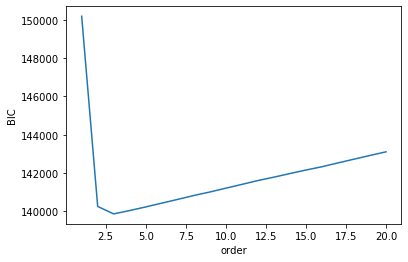

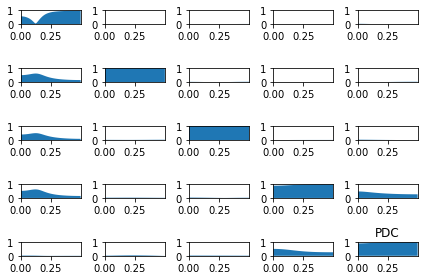

In [11]:
plt.close('all')

# example from the paper
A = np.zeros((3, 5, 5))
A[0, 0, 0] = 0.95 * math.sqrt(2)
A[1, 0, 0] = -0.9025
A[1, 1, 0] = 0.5
A[2, 2, 0] = -0.4
A[1, 3, 0] = -0.5
A[0, 3, 3] = 0.25 * math.sqrt(2)
A[0, 3, 4] = 0.25 * math.sqrt(2)
A[0, 4, 3] = -0.25 * math.sqrt(2)
A[0, 4, 4] = 0.25 * math.sqrt(2)

# simulate processes
n = 10 ** 4
# sigma = np.array([0.0001, 1, 1, 1, 1])
# sigma = np.array([0.01, 1, 1, 1, 1])
sigma = np.array([1., 1., 1., 1., 1.])
Y = mvar_generate(A, n, sigma)

mu = np.mean(Y, axis=1)
X = Y - mu[:, None]

# estimate AR order with BIC
if 1:
    p_max = 20
    p, bic = compute_order(X, p_max=p_max)

    plt.figure()
    plt.plot(np.arange(p_max + 1), bic)
    plt.xlabel('order')
    plt.ylabel('BIC')
    plt.show()
else:
    p = 3

A_est, sigma = mvar_fit(X, p)
sigma = np.diag(sigma)  # DTF + PDC support diagonal noise
# sigma = None

# compute DTF
"""D, freqs = DTF(A_est, sigma)
plot_all(freqs, D, 'DTF')"""

# compute PDC
P, freqs = PDC(A_est, sigma)
plot_all(freqs, P, 'PDC')
plt.show()
